# Modeling Short Time Series with Prior Knowledge in PyMC

In this notebook I want to reproduce in [PyMC](https://github.com/pymc-devs/pymc) the methodology described in the amazing blog post [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) by [Tim Radtke](https://minimizeregret.com/about/) to forecast short time series using *bayesian transfer learning*. The main idea is to transfer information (e.g. long term seasonality) from a long time series to a short time series via prior distributions. Tim's blog post treats a very concrete example where all the concepts become very concrete. The challenge of the example is to generate long term forecast for a short time series of bike sales data. Specifically, the input sales data consists of three months of daily data and the objective is to generate at least a two years forecast. In general this is very hard to to with commonly available methods (as we will show below) due the fact we do not have enough historical data to capture seasonal patterns. For this concrete example, we do expect to have a strong yearly seasonal pattern as bike sales are usually much higher during summer than in winter. Hence, we could use temperature as a proxy for this seasonal pattern. However, as mentioned above, we can not simply try to use such data in a model with just 3 months of daily data ... ¯\\_(ツ)_/¯ ... **Here s the elegant trick**: First, fit a model on long past historical temperature data through [Fourier modes](https://en.wikipedia.org/wiki/Fourier_series) (as in Facebook's [Prophet](https://facebook.github.io/prophet/) model). Then use the posterior means and standard deviations of each Fourier mode as the prior distribution for the sales short time series $y_t$. For the later model we use a [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) as the likelihood function (as we are modeling count data, i.e. the number of sales) and model the mean $\mu_t$ through three main components:

1. A *seasonal component* which consists of Fourier modes with the specified priors, dummy variables to model the weekly seasonality and a mild trend component.
2. We use an autoregressive term $\mu_{t -1}$ on the mean itself.
3. An autoregressive term $y_{t - 1}$ from the input sales data.

By combining the the long term seasonality learned in the temperature model in this way we can adapt it to match the scale of the sales data. We will describe the full model specification below.

 I was fortunate to see [Tim's talk](https://minimizeregret.com/post/2019/06/16/satrday-berlin-presentation/) about the subject back in 2019 during the [satRdays](https://berlin2019.satrdays.org/) Berlin conference (where I also gave a talk on [Remedies for Severe Class Imbalance](https://juanitorduz.github.io/class_imbalance/)). I remember listening to such great presentation ant thinking *Wow! This is a fantastic idea!* At that time I was not able to follow the modeling strategy 100%, but I kept the idea in mind. Since then, I have been faced a couple of times to the challenge of forecasting short time series where there is an expected seasonal pattern but not enough historical data. Of course, when there are many time series, the problem can be tackled using probabilistic forecasting as well (see for example [deepAR](https://arxiv.org/abs/1704.04110?context=stat.ML)). However, the strategy presented on Tim's blog post is very elegant and can serve situations where the number of time series is small (which is often the case in certain domains, e.g. marketing). Hence, I decided to try it out in PyMC! Moreover, while trying to reproduce this work I also learned some very useful things on the side:

- The particular models (which we describe below) to perform the transfer learning are very interesting (specially the local level model) and I can see similar variations being applicable in many real world problems.
- Learn to read [Stan](https://mc-stan.org/) code and understand how it works. This is because the code is provided in [R](https://www.r-project.org/) and the model is sampled using [Stan](https://mc-stan.org/). Please find the code of the blog post [here](https://github.com/timradtke/short-time-series) (kudos to Tim for sharing it and making the results fully reproducible!).
- Learn how to use [`aesara.scan`](https://aesara.readthedocs.io/en/latest/library/scan.html) to run loops efficiently inside a PyMC model. I must admit that learning how [`aesara.scan`](https://aesara.readthedocs.io/en/latest/library/scan.html)  works was not very easy and I really had to work a concrete example and carefully read documentation to get it work. I still need some more practice but I have a much better intuition now. I share some findings and extended explanations on an appendix at the end of this notebook.

I **strongly recommend to read Tim's original blog post** [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge) first to enjoy a clear understanding of the problem and the underlying ideas. The purpose of this notebook is mainly to reproduce his results (and the details behind the PyMC code) and not to give a detailed explanation of the model, specially the remarkable prior distributions analysis done by Tim.

*For the experienced readers:* if you have know a better way to re-write or optimize this PyMC implementation I would love to hear about it. The time it takes to sample is comparable to the time it takes to run the Stan code through R.

## Prepare Notebook

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## Read Data

We get the data from the original blog post repository [github.com/timradtke/short-time-series](https://github.com/timradtke/short-time-series). For the purpose of this notebook, I already combined (outer join on date) the sales and temperature data.

In [2]:
raw_df = pd.read_csv("../data/sales.csv", parse_dates=["date"])

raw_df.head()

,date,sales,temp
0,2013-07-01,57.0,303.0
1,2013-07-02,58.0,298.0
2,2013-07-03,53.0,301.0
3,2013-07-04,36.0,302.0
4,2013-07-05,29.0,305.0


## EDA

Let us start by  looking into the data.

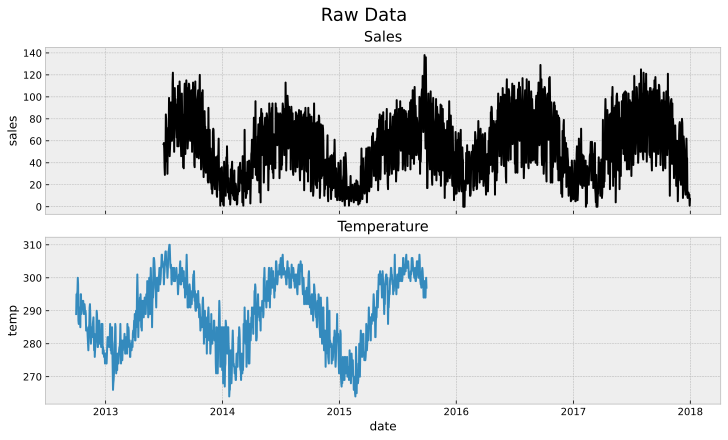

In [31]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="sales", data=raw_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df, color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature")
fig.suptitle("Raw Data", fontsize=18);

The first thing we observe is that we long data for both sales and temperature. Note however that our assumption is that we just have 3 months of historical sales data. The rest of the sales data is used as a "test set". On the other hand we do use all the available temperature data since the main idea s to have a predictor which is available in the future at prediction time (this could be the temperature forecast in real cases). Next, let us look at the sales data when both of them are not null:

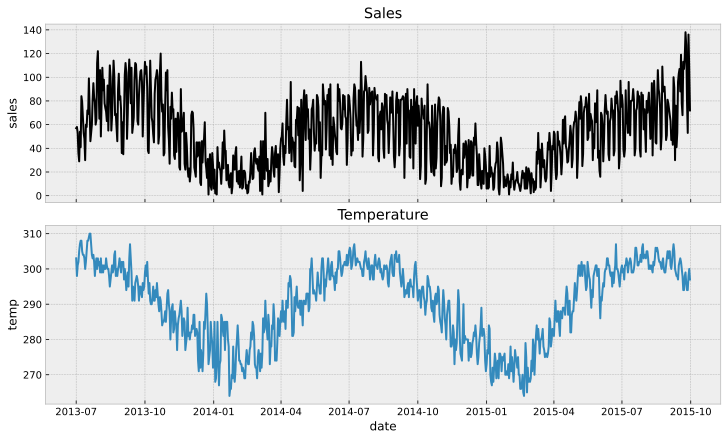

In [5]:
mask = "sales.notnull() and temp.notnull()"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df.query(mask), color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df.query(mask), color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

We see a strong yearly seasonal pattern both variables. Now we move intro the data preparation step.

## Data Preparation

Let us set the start and end date of the training set for the sales model.

In [22]:
start_date = pd.to_datetime("2013-07-01")
train_test_date = pd.to_datetime("'2013-10-15'")

print(f"Training Set Length: {(train_test_date - start_date).days} days")

Training Set Length: 106 days


Now we split the data accordingly. In the process we also add two features:
1. We scale the temperature data.
2. We create a trend component.

In [25]:
# data points before the start of the training set
n_init = raw_df.sort_values("date").query("date < '2013-07-01'").shape[0]

df = (
    raw_df.query("temp.notnull()")
    .sort_values("date")
    .reset_index(drop=True)
    .eval(
        """
        temp_scaled = temp - temp.min()
        trend = (sales.index - @n_init + 1) / 365.25
    """
    )
)


df_train = df.query("date < @train_test_date & sales.notnull()")
df_test = df.query("date >= @train_test_date")

n_train = df_train.shape[0]
n_test = df_test.shape[0]
n = n_test + n_train

Let;s visualize the sales model training set.

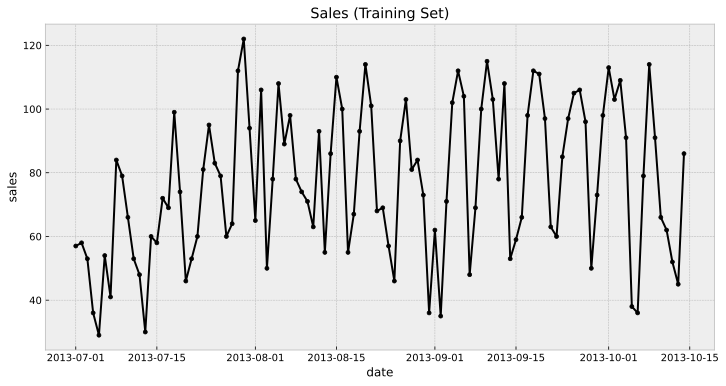

In [33]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    color="black",
    marker="o",
    markersize=4,
    markeredgecolor="black",
    ax=ax,
)
ax.set(title="Sales (Training Set)");

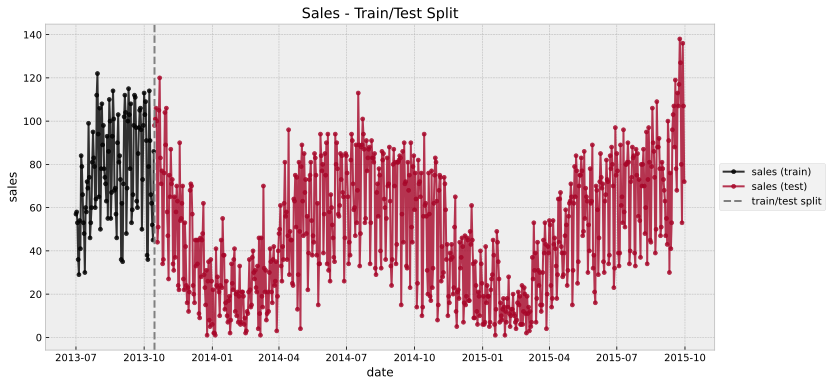

In [32]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Sales - Train/Test Split");

## Temperature Model

In [ ]:
date = df["date"]
temp_scaled = df["temp_scaled"]
trend = df["trend"]
sales = df["sales"]
dayofweek_idx, dayofweek = df["date"].dt.dayofweek.factorize()

In [ ]:
periods = df["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

In [ ]:
coords = {
    "date": date,
    "fourier_features": np.arange(2 * n_order),
}

with pm.Model(coords=coords) as temp_model:
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=1)
    ## seasonality
    b_fourier = pm.Normal(name="b_fourier", mu=0, sigma=1, dims="fourier_features")
    # --- model parametrization ---
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T), dims="date"
    )
    mu = pm.Deterministic(name="mu", var= a + seasonality, dims="date")

    # --- likelihood ---
    pm.Poisson("likelihood", mu=pm.math.exp(mu), observed=temp_scaled, dims="date")

pm.model_to_graphviz(temp_model)

In [ ]:
with temp_model:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Temperature Model");

In [ ]:
with temp_model:
    temp_idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)

In [ ]:
az.summary(data=temp_idata, var_names=["a", "b_fourier"])

In [ ]:
ax = az.plot_forest(
    data=temp_idata,
    var_names=["b_fourier"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Temperature Model - Posterior Distributions Fourier Modes", fontsize=16
);

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date", y="temp_scaled", data=df, color="C0", label="temp (scaled)", ax=ax
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=temp_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Temperature Model");

## Sales Model

In [ ]:
date_train = df_train["date"]
sales_train = df_train["sales"]
trend_train = df_train["trend"]
dayofweek_idx_train, dayofweek_train = df_train["date"].dt.dayofweek.factorize()

In [ ]:
temp_model_summary = az.summary(data=temp_idata, var_names=["b_fourier"])
fourier_loc = temp_model_summary["mean"]
fourier_sd = temp_model_summary["sd"]

In [ ]:
periods_train = df_train["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features_train = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods_train * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

In [ ]:
coords = {
    "fourier_features": np.arange(2 * n_order),
    "dayofweek": dayofweek_train,
}

with pm.Model(coords=coords) as sales_model:
    # --- data containers ---
    sales_model.add_coord(name="date", values=date_train, mutable=True)
    trend_data = pm.MutableData(name="trend", value=trend_train, dims="date")
    sales_data = pm.MutableData(name="sales", value=sales_train, dims="date")

    # --- priors ---
    delta = pm.Beta(name="delta", alpha=1, beta=10)
    eta = pm.Gamma(name="eta", alpha=0.5, beta=10)
    b_fourier = pm.Normal(
        name="b_fourier", mu=fourier_loc, sigma=fourier_sd, dims="fourier_features"
    )
    b_dayofweek = pm.Normal(name="b_dayofweek", mu=4, sigma=2, dims="dayofweek")
    b_trend = pm.Normal(name="b_trend", mu=0.03, sigma=0.02)
    alpha_inv = pm.Normal(name="mu_inv", mu=0, sigma=0.5)

    # --- model parametrization ---
    ## parameters constraints
    pm.Potential(name="constrain", var=at.switch(eta > 1 - delta, -np.inf, 0))
    # transferred trend and seasonality
    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pm.math.dot(b_fourier, fourier_features_train.to_numpy().T),
        dims="date",
    )
    dayofweek_contribution = pm.Deterministic(
        name="dayofweek_contribution", var=b_dayofweek[dayofweek_idx_train], dims="date"
    )
    trend_contribution = pm.Deterministic(
        name="trend_contribution", var=b_trend * trend_data, dims="date"
    )
    seasonality = pm.Deterministic(
        name="seasonality",
        var=pymc.math.exp(
            fourier_contribution + dayofweek_contribution + trend_contribution
        ),
        dims="date",
    )
    ## damped dynamic mean
    mu0 = pm.MutableData(
        name="mu0", value=np.zeros(sales_data.shape.eval()[0]), dims="date"
    )
    mu0 = at.set_subtensor(mu0[0], sales_data[0])

    def one_step(seasonality_t, sales_tm1, mu_tm1, delta, eta):
        return (1 - delta - eta) * seasonality_t + delta * mu_tm1 + eta * sales_tm1

    outputs, _ = aesara.scan(
        fn=one_step,
        sequences=[
            dict(input=seasonality[1:], taps=[0]),
            dict(input=sales_data, taps=[-1]),
        ],
        outputs_info=dict(initial=mu0, taps=[-1]),
        non_sequences=[delta, eta],
        strict=True,
    )
    mu = pm.Deterministic(
        name="mu", var=at.set_subtensor(mu0[1:], outputs[:, 0]), dims="date"
    )
    alpha = pm.Deterministic(name="alpha", var=1 / pm.math.sqr(alpha_inv))

    # --- likelihood ---
    pm.NegativeBinomial(
        name="likelihood", alpha=alpha, mu=mu, observed=sales_data, dims="date"
    )

pm.model_to_graphviz(sales_model)


In [ ]:
# plt.plot(mu.eval())
# plt.plot(sales_train.reset_index(drop=True))

In [ ]:
# alpha0 = at.zeros(sales_data.shape.eval()[0])
# alpha0 = at.set_subtensor(alpha0[0], sales_data[0])

# d = 0.51
# e = 0.5

# def one_step(seasonality_t, sales_tm1, alpha_tm1, delta, eta):
#     return (1 - delta - eta) * seasonality_t + delta * alpha_tm1 + eta * sales_tm1

# outputs, _ = aesara.scan(
#         fn=one_step,
#         sequences=[dict(input=seasonality[1:], taps=[-0]), dict(input=sales_data, taps=[-1])],
#         outputs_info=dict(initial=alpha0, taps=[-1]),
#         non_sequences=[delta, eta],
#         strict=True,
#     )

In [ ]:
# one_step(seasonality[1], sales_data[0], alpha0[0], delta, eta).eval()
# alpha0 = at.set_subtensor(alpha0[1], one_step(seasonality[1], sales_data[0], alpha0[0], delta, eta).eval())
# one_step(seasonality[2], sales_data[1], alpha0[1], delta, eta).eval()
# alpha0 = at.set_subtensor(alpha0[2], one_step(seasonality[2], sales_data[1], alpha0[1], delta, eta).eval())
# one_step(seasonality[3], sales_data[2], alpha0[2], delta, eta).eval()
# alpha0.eval()

In [ ]:
# alpha.eval()

In [ ]:
# outputs.eval()

In [ ]:
#outputs[: , 0].eval()

In [ ]:
with sales_model:
    sales_prior_predictive = pm.sample_prior_predictive(samples=1000)

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
)
az.plot_hdi(
    x=date_train,
    y=sales_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_prior_predictive.prior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior HDI Sales Model");


In [ ]:
with sales_model:
    sales_idata = pm.sample(
        target_accept=0.95, draws=4_000, chains=4
    )
    sales_posterior_predictive = pm.sample_posterior_predictive(trace=sales_idata)

In [ ]:
var_names = ["b_fourier", "b_dayofweek","b_trend", "delta", "eta", "alpha"]

In [ ]:
az.summary(data=sales_idata, var_names=var_names)

In [ ]:
axes = az.plot_trace(
    data=sales_idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Sales Model - Trace", fontsize=16);

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
)
az.plot_hdi(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.95,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
sns.lineplot(
    x=date_train,
    y=sales_posterior_predictive.posterior_predictive["likelihood"]
    .stack(samples=("chain", "draw"))
    .mean(axis=1),
    marker="o",
    color="C0",
    markersize=4,
    markeredgecolor="C0",
    label="mean posterior predictive",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior HDI Sales Model")


In [ ]:
# with sales_model:
#     pm.set_data(new_data={"sales": sales}, coords={"date": date})
#     sales_idata.extend(
#         other=pm.sample_posterior_predictive(
#             trace=sales_idata,
#             var_names=["likelihood"],
#             idata_kwargs={"coords": {"date": date}},
#         ),
#         join="right",
#     )


In [ ]:
posterior = sales_idata.posterior.stack(samples=("chain", "draw"))

In [ ]:
seasonality_posterior = np.exp(
    posterior["b_trend"].to_numpy()[..., None] * trend[-n:][None, ...]
    + posterior["b_dayofweek"][dayofweek_idx[-n:]].T
    + np.tensordot(
        a=posterior["b_fourier"], b=fourier_features[-n:], axes=[[0], [1]]
    ).reshape(-1, n)
)

seasonality_posterior.shape

In [ ]:
sales_train_posterior = sales_posterior_predictive.posterior_predictive[
    "likelihood"
].stack(samples=("chain", "draw")).T

sales_train_posterior.shape

In [ ]:
n_samples = 4000 * 4

In [ ]:
sales_posterior = np.zeros(shape=(n_samples, n))
sales_posterior[:, :n_train] = sales_train_posterior
sales_posterior.shape

In [ ]:
mu_posterior = np.zeros(shape=(n_samples, n))
mu_posterior[:, :n_train] = posterior["mu"].T
mu_posterior.shape

In [ ]:
from tqdm.notebook import tqdm

for t in tqdm(range(n_train, n)):
    
    mu_posterior[:, t] = (
        ((1 - posterior["delta"] - posterior["eta"]) * seasonality_posterior[:, t])
        + (posterior["delta"] * mu_posterior[:, t - 1])
        + (posterior["eta"] * sales_posterior[:, t - 1])
    )

    likelihood = pm.NegativeBinomial.dist(
        name="posterior_sales", mu=mu_posterior[:, t], alpha=posterior["alpha"].to_numpy()
    )

    sales_posterior[:, t] = pm.draw(likelihood)

In [ ]:
sales_posterior_hdi95 = az.hdi(sales_posterior, hdi_prob=0.95)
sales_posterior_hdi50 = az.hdi(sales_posterior, hdi_prob=0.50)

fig, ax = plt.subplots(figsize=(15, 7))

ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi95[:, 0],
    y2=sales_posterior_hdi95[:, 1],
    color="C0",
    label="HDI 95%",
    alpha=0.5,
)
ax.fill_between(
    x=date[-n:],
    y1=sales_posterior_hdi50[:, 0],
    y2=sales_posterior_hdi50[:, 1],
    color="C0",
    label="HDI 50%",
    alpha=0.7,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="sales",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="upper left")
ax.set(title="Sales Model - Out of Sample Predictions");
